# AP-1 Figures

In [4]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import networkx as nx
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
sys.path.append("/home/jenhan/code/seq_merge_pipe/")
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(5000)
os.chdir('/home/jenhan/analysis/cobinding_motif_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions

In [153]:

def get_GC_matched_split(features, labels, test_size, tolerance = 0.01):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    tolerance: max difference in GC content between True and False labelled samples
    '''
    global _id_sequence_dict
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if x[1]]
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if not x[1]]
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    # calculate GC content of True samples
    true_gc_count = 0
    true_length = 0
    for s in true_sequences:
        true_gc_count += s.count('G')
        true_gc_count += s.count('C')
        true_length += len(s)
    true_gc_content = true_gc_count/(true_length+0.0000001)
    
    # calcuate GC content of False samples
    false_gc_count = 0
    false_length = 0
    for s in false_sequences:
        false_gc_count += s.count('G')
        false_gc_count += s.count('C')
        false_length += len(s)
    false_gc_content = false_gc_count/(false_length+0.0000001)
    
    while abs(true_gc_content - false_gc_content) > tolerance:
        # remove false GC sequences until GC content matches tolerance
        selected_seq = False
        
        while not selected_seq:
            rand_index = np.random.randint(len(false_sequences))
            current_seq = false_sequences[rand_index]
            current_gc_count = current_seq.count('G')+ current_seq.count('C')
            current_length = len(current_seq)
            current_gc = current_gc_count/current_length
            if true_gc_content > false_gc_content:
                # remove sequences that would increase overall GC content of False sequences
                if current_gc < false_gc_content:
                    selected_seq = True
            else:
                # remove sequences that would decrease overall GC content of False sequences
                if current_gc > false_gc_content:
                    selected_seq = True
        false_gc_count -= current_gc_count
        false_length -= current_length
        false_gc_content = false_gc_count/false_length
        
        false_sequences.pop(rand_index)
        false_ids.pop(rand_index)
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

#     print('total:',features.shape[0], 'filtered:',filtered_features.shape[0], 'true gc:',np.round(true_gc_content,5), 'false gc:', np.round(false_gc_content,5), 'difference:',np.round(abs(true_gc_content - false_gc_content),5))

#     training_features, test_features, training_labels, test_labels = train_test_split(
#         filtered_features, filtered_labels, 
#         test_size =test_size, 
#         random_state=np.random.RandomState(0),
#         )
    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    
#     n_samples = filtered_features.shape[0]
#     n_features = filtered_features.shape[1]

#     # shuffle and split training and test sets
#     filtered_features, filtered_labels = shuffle(filtered_features, filtered_labels, random_state=np.random.RandomState(0))
#     split = int(0.80*n_samples)
#     training_features, test_features = filtered_features[:split], filtered_features[split:]
#     training_labels, test_labels = filtered_labels[:split], filtered_labels[split:]
    
    return training_features, test_features, training_labels, test_labels
    

## Read in Score Files

In [10]:
motif_score_frame=pd.read_pickle('motif_score_frame_C57BL6J.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame_C57BL6J.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame_C57BL6J.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame_C57BL6J.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame_C57BL6J.pickle')
summary_frame = pd.read_pickle('summary_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')

# normed_motif_frame = pd.DataFrame(preprocessing.normalize(merged_motif_frame.ix[:,3:], axis=0))
scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values
_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
_factors.remove('atac')
scaler = preprocessing.MinMaxScaler()
normed_summary_frame = pd.DataFrame(scaler.fit_transform(summary_frame.ix[:,5:]))
normed_summary_frame.columns = summary_frame.columns.values[5:]
normed_summary_frame.index = summary_frame.index.values

scaled_motif_frame = pd.DataFrame()
for m in motif_score_frame.columns[3:]:
    scaled_motif_frame[m] = motif_score_frame[m]/(2*motif_sequence_frame[m].str.len().max())


### read in sequences as dictionary {peakID: sequence}
with open('./peak_sequences/C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()    

In [11]:
### work with just intergenic peaks for now ###
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
intergenic_motif_score_frame = motif_score_frame[motif_score_frame.index.isin(intergenic_ids)]
intergenic_motif_sequence_frame = motif_sequence_frame[motif_sequence_frame.index.isin(intergenic_ids)]
intergenic_motif_start_frame = motif_start_frame[motif_start_frame.index.isin(intergenic_ids)]
intergenic_motif_end_frame = motif_end_frame[motif_end_frame.index.isin(intergenic_ids)]
intergenic_normed_motif_frame = normed_motif_frame[normed_motif_frame.index.isin(intergenic_ids)]
intergenic_scaled_motif_frame = scaled_motif_frame[scaled_motif_frame.index.isin(intergenic_ids)]
intergenic_summary_frame = summary_frame[summary_frame.index.isin(intergenic_ids)]
intergenic_annotation_frame = annotation_frame[annotation_frame.index.isin(intergenic_ids)]



In [12]:
ap1_members=['atf3', 'cjun', 'fos', 'fra1', 'fra2', 'jdp2', 'junb', 'jund']
contains_ap1 = summary_frame[['c57bl6_'+x+'_veh' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_veh' if x[1] == True else x[2] for x in contains_ap1_tuples]

contains_ap1 = summary_frame[['c57bl6_'+x+'_kla' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_kla' if x[1] == True else x[2] for x in contains_ap1_tuples]

# Figure 1 - AP-1 Cistrome

### Expression of AP-1 monomers before and after KLA treatment

In [ ]:
%%bash
analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d  /home/jenhan/analysis/ap1_analysis/tag_directories_rna/*UT*/> rpkm.tsv

%%bash
python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv ./rna_idr KLA KLA Veh Veh

In [14]:
idr_rpkm_frame = pd.read_csv('rna_idr/idr_intersection_rpkm.tsv', sep='\t')

columns = idr_rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = '_'.join(columns[i].split('/')[-1].split('_')[3:5])
idr_rpkm_frame.columns = columns    
idr_rpkm_frame['gene'] = [x.split("|")[0].upper() for x in idr_rpkm_frame['Annotation/Divergence'].values]
idr_rpkm_frame.index = idr_rpkm_frame['gene'].values

idr_rpkm_mean_frame = pd.DataFrame()

for treatment in idr_rpkm_frame.columns.values[8:-1]:
    idr_rpkm_mean_frame[treatment] = np.mean(idr_rpkm_frame[treatment].astype(float), axis=1)

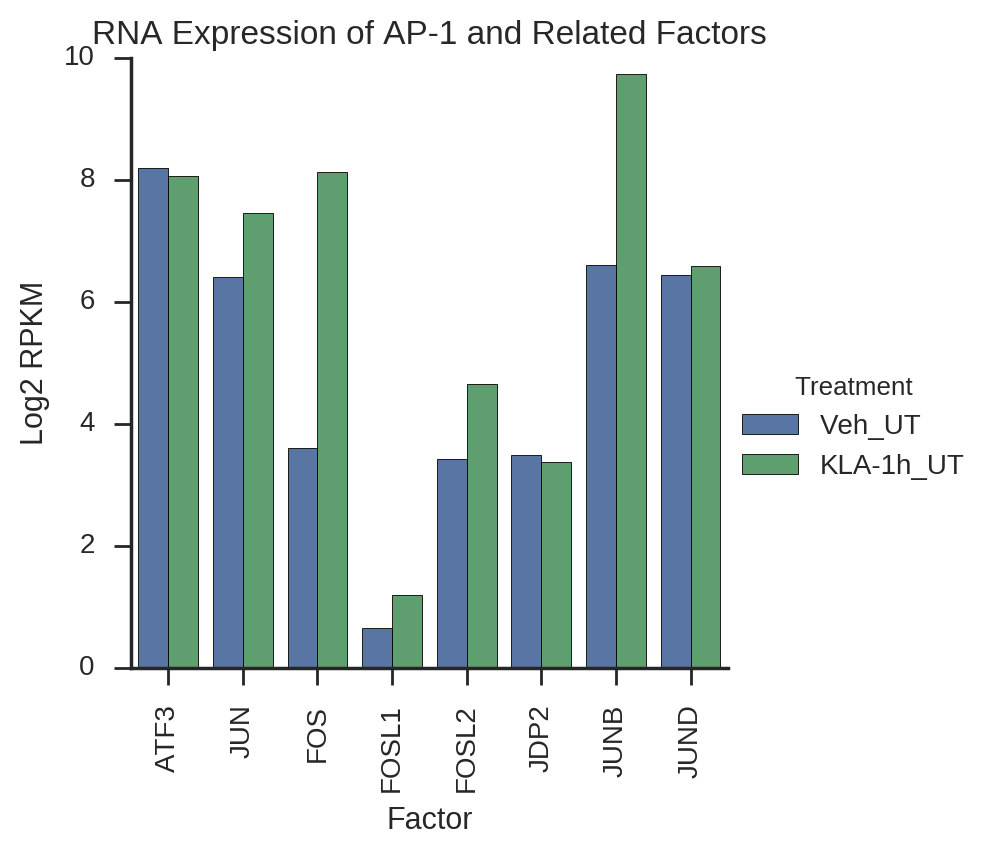

In [17]:
plottingFrame = pd.DataFrame(idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(
            ['ATF3', 'JUN', 'FOS', 'FOSL1', 'FOSL2' ,'JDP2', 'JUNB', 'JUND'])].stack())
# plottingFrame = pd.DataFrame(idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(
#             ['ATF3', 'JUN', 'FOS', 'FOSL1', 'FOSL2' ,'JDP2', 'JUNB', 'JUND', 'CEBPA', 'SPI1', 'REL','RELA'])].stack())


plottingFrame['Factor'] = [x[0] for x in plottingFrame.index.values]
plottingFrame['Treatment'] = [x[1] for x in plottingFrame.index.values]
plottingFrame.columns = ['RPKM', 'Factor', 'Treatment']
plottingFrame['Log2 RPKM'] = np.log2(plottingFrame['RPKM'].values + 1)
with sns.axes_style('ticks'):
    sns.factorplot(data = plottingFrame, x='Factor', y='Log2 RPKM', hue='Treatment', kind='bar', 
                   hue_order=['Veh_UT','KLA-1h_UT'], 
                   order = ['ATF3', 'JUN', 'FOS', 'FOSL1', 'FOSL2' ,'JDP2', 'JUNB', 'JUND'],#, 'CEBPA', 'SPI1', 'REL','RELA']
                  size=4)
plt.title('RNA Expression of AP-1 and Related Factors')
plt.xticks(rotation=90)
plt.savefig('/home/jenhan/analysis/cobinding_motif_analysis/figures/figure_01_a.svg', bbox_inches='tight')

### Heatmap of Vehicle Cistrome

In [18]:
### create tag matrix
!annotatePeaks.pl ./merged_peaks_filtered.tsv mm10 -size given -d ./tag_directories_ap1/* /home/jenhan/analysis/ap1_analysis/tag_directories/*p65*> merged_annotated_peaks_ap1.tsv


	Peak file = ./merged_peaks_filtered.tsv
	Genome = mm10
	Organism = mouse
	Using actual sizes of regions
	Peak Region set to given
	Tag Directories:
		./tag_directories_ap1/C57Bl6_Thiomac_ChIP_ATF3_KLA-1h_GJF_16-04-21
		./tag_directories_ap1/C57Bl6_Thiomac_ChIP_ATF3_Veh_GJF_16-04-21
		./tag_directories_ap1/C57Bl6_Thiomac_ChIP_Fos_KLA-1h_GJF_14-03-17
		./tag_directories_ap1/C57Bl6_Thiomac_ChIP_Fos_KLA-1h_GJF_16-04-21
		./tag_directories_ap1/C57Bl6_Thiomac_ChIP_Fos_Veh_GJF_14-03-17
		./tag_directories_ap1/C57Bl6_Thiomac_ChIP_Fos_Veh_GJF_16-04-21
		./tag_directories_ap1/C57Bl6_Thiomac_ChIP_Fra1_KLA-1h_GJF_14-03-17
		./tag_directories_ap1/C57Bl6_Thiomac_ChIP_Fra1_KLA-1h_GJF_16-04-21
		./tag_directories_ap1/C57Bl6_Thiomac_ChIP_Fra1_Veh_GJF_14-03-17
		./tag_directories_ap1/C57Bl6_Thiomac_ChIP_Fra1_Veh_GJF_16-04-21
		./tag_directories_ap1/C57Bl6_Thiomac_ChIP_Fra2_KLA-1h_GJF_14-03-17
		./tag_directories_ap1/C57Bl6_Thiomac_ChIP_Fra2_KLA-1h_GJF_16-04-21
		./tag_directories_ap1/C57Bl6_Thiomac_Ch

In [19]:
# average tag counts from both replicates
ap1_tag_frame = pd.read_csv('merged_annotated_peaks_ap1.tsv', sep='\t')
ap1_tag_frame.index = ap1_tag_frame.ix[:,0].values
ap1_tag_frame = ap1_tag_frame[[x for x in ap1_tag_frame.columns.values if 'Tag Count' in x]]
columns = [x.split(' ')[0].split('/')[-1] for x in ap1_tag_frame.columns.values]
ap1_tag_frame.columns = columns

factor_treatments = sorted(set(['_'.join(x.split('_')[3:5]).split('-')[0] for x in columns]))

ap1_meanTag_frame = ap1_tag_frame[[]]
for ft in factor_treatments:
    ap1_meanTag_frame[ft] = ap1_tag_frame[[x for x in ap1_tag_frame.columns if ft in x]].mean(axis=1)

In [ ]:
# clustermap for Vehicle
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values
data = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(c57bl6_indices)]\
    [['ATF3_Veh','cJun_Veh', 'Fos_Veh', 'Fra1_Veh', 'Fra2_Veh', 'Jdp2_Veh', 'JunB_Veh', 'JunD_Veh','Input_Veh']]

logged_data = np.log2(data+1)
cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=[x.split('_')[0] for x in data.columns],
          cmap='Blues',
          col_cluster=False,
          vmax=8)
plt.savefig('/home/jenhan/analysis/cobinding_motif_analysis/figures/figure_01_b.svg', bbox_inches='tight')

### Heatmap of KLA Cistrome

In [ ]:
# clustermap for KLA
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values
data = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(c57bl6_indices)]\
    [['ATF3_KLA','cJun_KLA', 'Fos_KLA', 'Fra1_KLA', 'Fra2_KLA', 'Jdp2_KLA', 'JunB_KLA', 'JunD_KLA', 'p65_KLA','Input_KLA']]

logged_data = np.log2(data+1)
cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=[x.split('_')[0] for x in data.columns],
          cmap='Reds',
          col_cluster=False,
          vmax=8)
plt.savefig('/home/jenhan/analysis/cobinding_motif_analysis/figures/figure_01_c.svg', bbox_inches='tight')

### Stacked barplot summarizing heatmaps

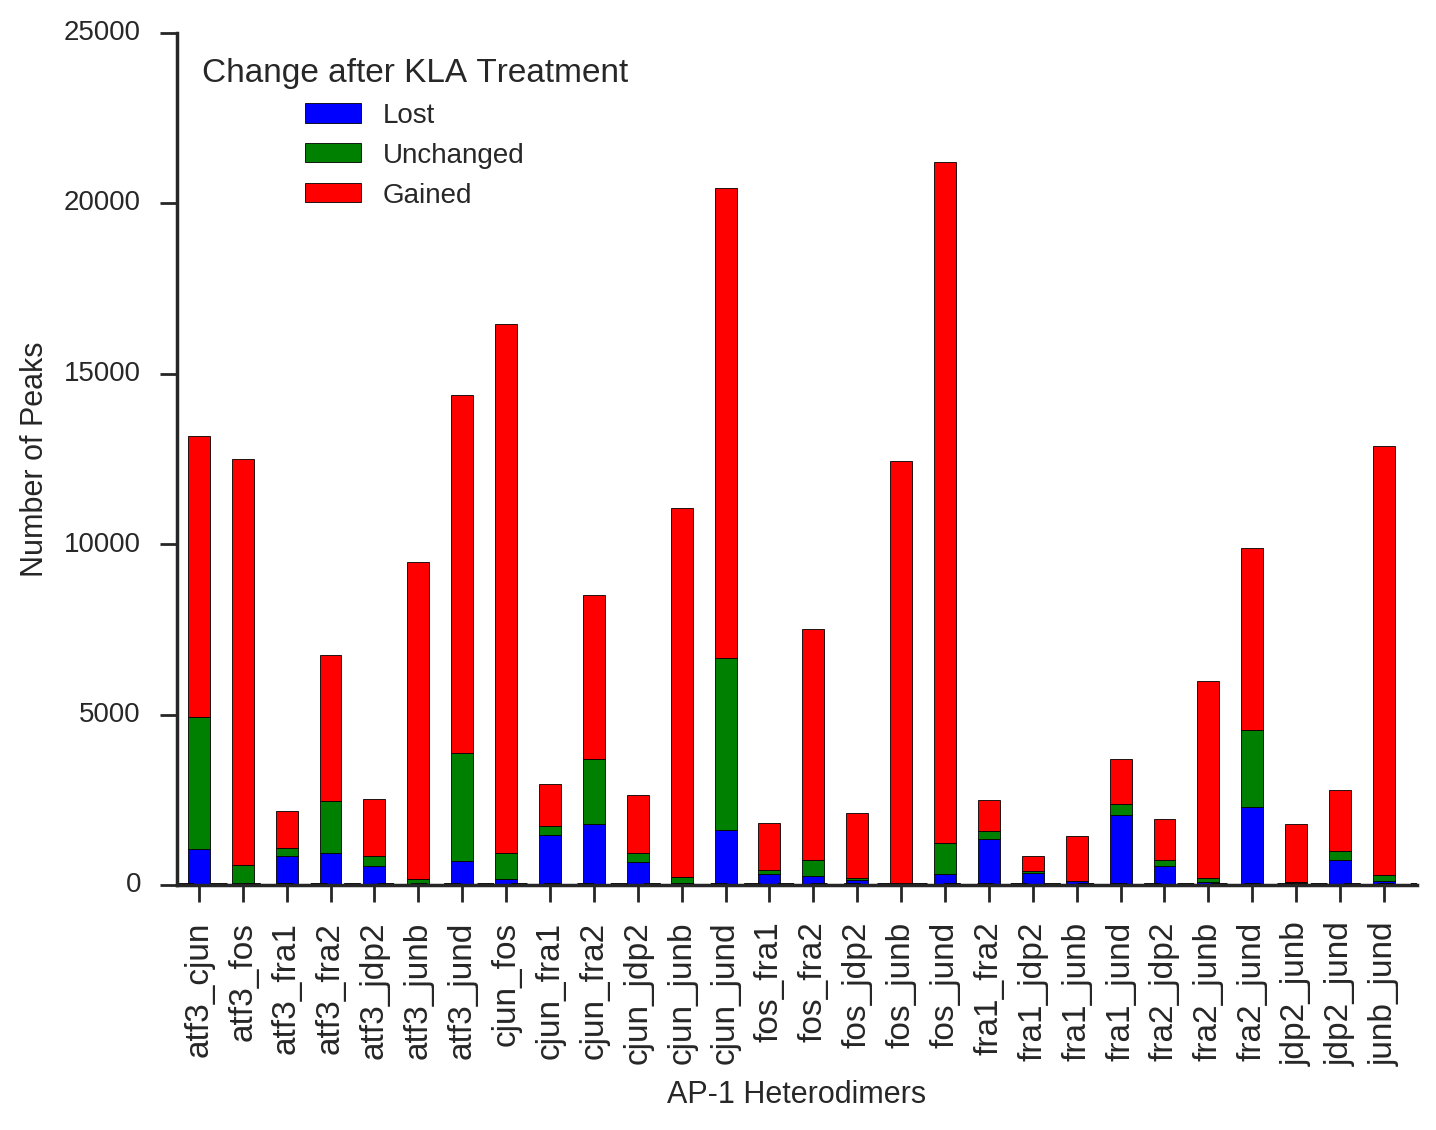

In [207]:
threshold = 0
ap1_members = ['atf3', 'cjun', 'fos', 'fra1', 'fra2','jdp2', 'junb', 'jund']
factors = []
veh_counts = []
both_counts = []
kla_counts = []

veh_columns = ['c57bl6_' + x + '_veh' for x in ap1_members]
kla_columns = ['c57bl6_' + x + '_kla' for x in ap1_members]


for i in range(len(ap1_members)):
    factor1 = ap1_members[i]
    for j in range(i, len(ap1_members)):
        factor2 = ap1_members[j]
        
        if factor1 == factor2:
            veh_indices = set(summary_frame[(summary_frame['c57bl6_' + factor1 + '_veh'] > 0) & 
                                       (summary_frame['c57bl6_' + factor1 + '_veh'] == summary_frame[veh_columns].sum(axis=1))].index.values)
            kla_indices = set(summary_frame[(summary_frame['c57bl6_' + factor1 + '_kla'] > 0) & 
                                       (summary_frame['c57bl6_' + factor1 + '_kla'] == summary_frame[kla_columns].sum(axis=1))].index.values)
        else:
            veh_indices = set(summary_frame[(summary_frame['c57bl6_' + factor1 + '_veh'] > 0) & 
                                       (summary_frame['c57bl6_' + factor2 + '_veh'] > 0)].index.values)
            kla_indices = set(summary_frame[(summary_frame['c57bl6_' + factor1 + '_kla'] > 0) & 
                                       (summary_frame['c57bl6_' + factor2 + '_kla'] > 0)].index.values)
        
        veh_count = len(veh_indices.difference(kla_indices))
        both_count = len(veh_indices.intersection(kla_indices))
        kla_count = len(kla_indices.difference(veh_indices))
        
        if max([veh_count, both_count, kla_count]) > threshold and not factor1==factor2:
            if factor1 == factor2:
                factors .append(factor1)
            else:            
                factors.append(factor1 + '_' + factor2)
            veh_counts.append(veh_count)
            both_counts.append(both_count)
            kla_counts.append(kla_count)
plottingFrame = pd.DataFrame({'Lost':veh_counts,
                              'Unchanged':both_counts,
                              'Gained':kla_counts})
plottingFrame = plottingFrame[['Lost', 'Unchanged', 'Gained']]
plottingFrame.index = factors
with sns.axes_style('ticks',{'axes.grid':False, 'grid.color':'white'}):
    plottingFrame.plot(kind='bar',stacked=True)
    sns.despine()
    plt.gca().get_legend().set_title('Change after KLA Treatment')
    plt.xlabel('AP-1 Heterodimers')
    plt.ylabel('Number of Peaks')

plt.savefig('./figures/figure_01_d.svg', bbox_inches='tight')

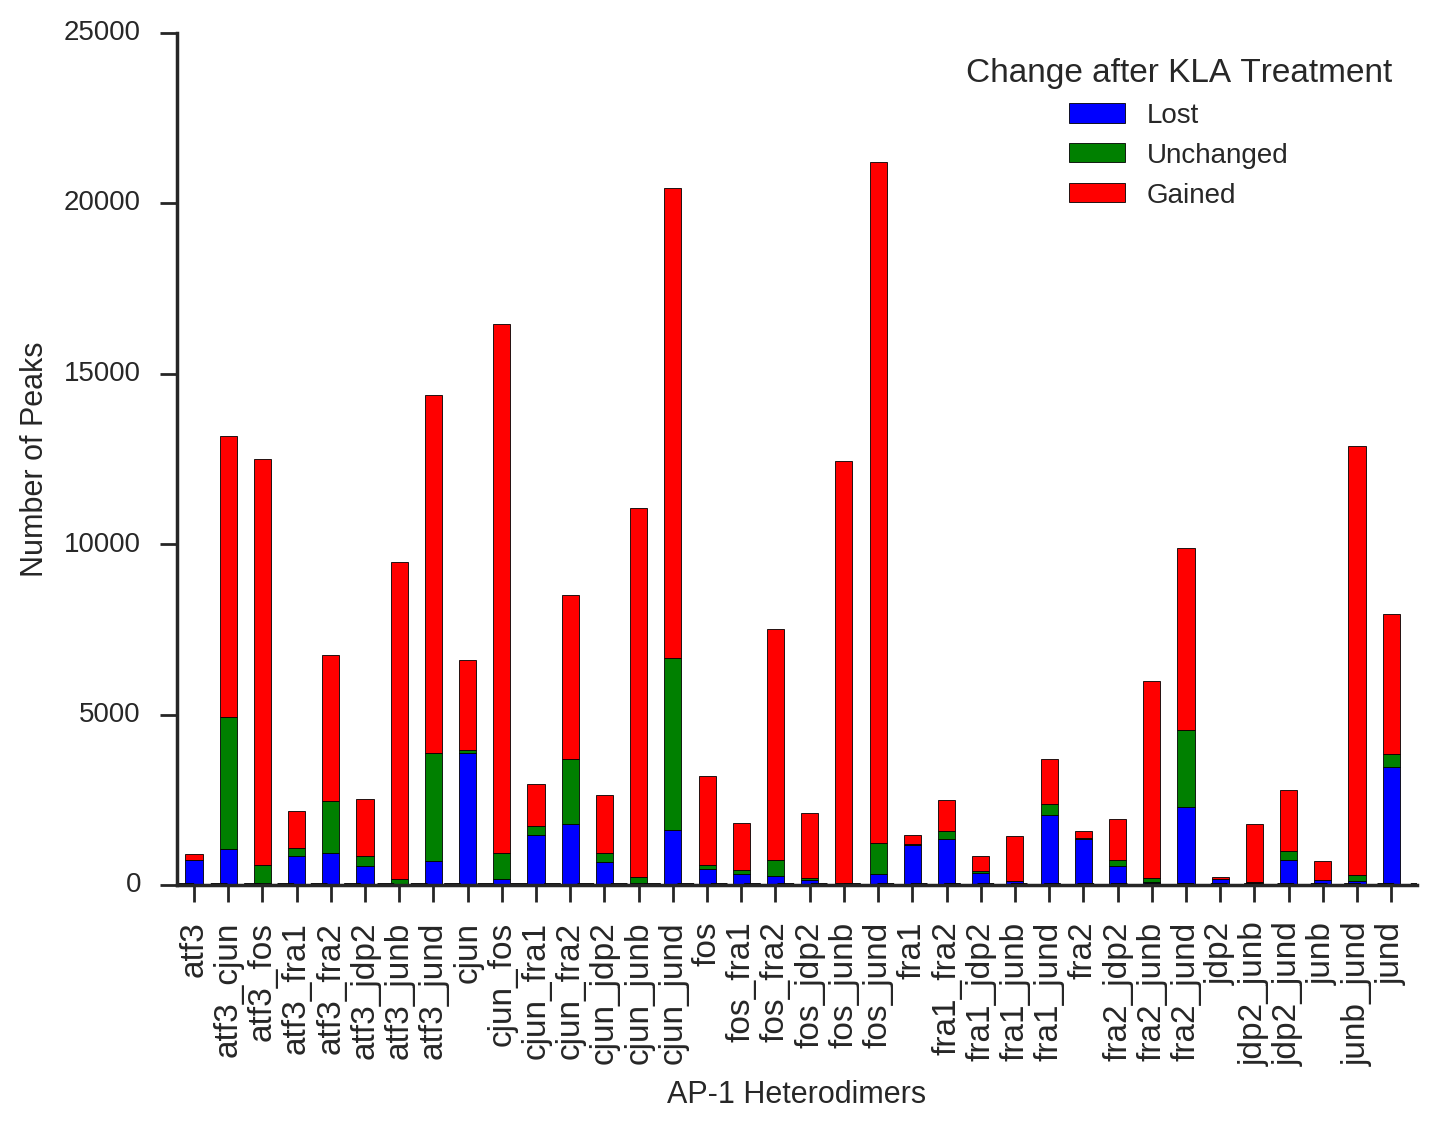

In [86]:
threshold = 0
ap1_members = ['atf3', 'cjun', 'fos', 'fra1', 'fra2','jdp2', 'junb', 'jund']
factors = []
veh_counts = []
both_counts = []
kla_counts = []

veh_columns = ['c57bl6_' + x + '_veh' for x in ap1_members]
kla_columns = ['c57bl6_' + x + '_kla' for x in ap1_members]


for i in range(len(ap1_members)):
    factor1 = ap1_members[i]
    for j in range(i, len(ap1_members)):
        factor2 = ap1_members[j]
        
        if factor1 == factor2:
            veh_indices = set(summary_frame[(summary_frame['c57bl6_' + factor1 + '_veh'] > 0) & 
                                       (summary_frame['c57bl6_' + factor1 + '_veh'] == summary_frame[veh_columns].sum(axis=1))].index.values)
            kla_indices = set(summary_frame[(summary_frame['c57bl6_' + factor1 + '_kla'] > 0) & 
                                       (summary_frame['c57bl6_' + factor1 + '_kla'] == summary_frame[kla_columns].sum(axis=1))].index.values)
        else:
            veh_indices = set(summary_frame[(summary_frame['c57bl6_' + factor1 + '_veh'] > 0) & 
                                       (summary_frame['c57bl6_' + factor2 + '_veh'] > 0)].index.values)
            kla_indices = set(summary_frame[(summary_frame['c57bl6_' + factor1 + '_kla'] > 0) & 
                                       (summary_frame['c57bl6_' + factor2 + '_kla'] > 0)].index.values)
        
        veh_count = len(veh_indices.difference(kla_indices))
        both_count = len(veh_indices.intersection(kla_indices))
        kla_count = len(kla_indices.difference(veh_indices))
        
        if max([veh_count, both_count, kla_count]) > threshold:
            if factor1 == factor2:
                factors.append(factor1)
            else:            
                factors.append(factor1 + '_' + factor2)
            veh_counts.append(veh_count)
            both_counts.append(both_count)
            kla_counts.append(kla_count)
plottingFrame = pd.DataFrame({'Lost':veh_counts,
                              'Unchanged':both_counts,
                              'Gained':kla_counts})
plottingFrame = plottingFrame[['Lost', 'Unchanged', 'Gained']]
plottingFrame.index = factors
with sns.axes_style('ticks',{'axes.grid':False, 'grid.color':'white'}):
    plottingFrame.plot(kind='bar',stacked=True)
    sns.despine()
    plt.gca().get_legend().set_title('Change after KLA Treatment')
    plt.xlabel('AP-1 Heterodimers')
    plt.ylabel('Number of Peaks')

plt.savefig('./figures/figure_01_d_withHomoDimers.svg', bbox_inches='tight')

### Scatter plot of tag counts for two similar monomers

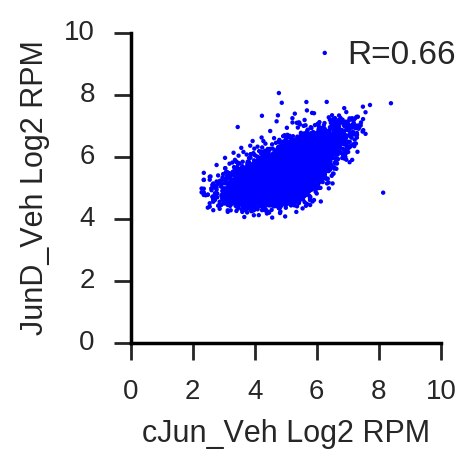

In [230]:
monomer1 = 'cJun_Veh'
monomer2 = 'JunD_Veh'
plt.figure(figsize=(2,2))
indices = summary_frame[(summary_frame['c57bl6_' + monomer1.lower()] > 0) & 
                        (summary_frame['c57bl6_' + monomer2.lower()] > 0)].index.values
x_vals = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(indices)][monomer1]
y_vals = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(indices)][monomer2]

log_x_vals = np.log2(x_vals + 1)
log_y_vals = np.log2(y_vals + 1)
with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                         }):
    plt.scatter(log_x_vals, 
                log_y_vals, 
                marker = '.', 
                s=10,
                edgecolors='none')
    
    sns.despine()
    # annotate axes 
    plt.xlabel(monomer1 + ' Log2 RPM')
    plt.ylabel(monomer2 + ' Log2 RPM')
    pearson, pearson_p = scipy.stats.pearsonr(x_vals, y_vals)
    plt.annotate(xy=(7,9), s='R='+ '{:.2f}'.format(pearson), )
    plt.xlim(0,10)
    plt.ylim(0,10)

    # Fix axes
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    
    plt.savefig('./figures/figure_01_e.svg', bbox_inches='tight')

### Scatter plot of tag counts for two dissimilar monomers

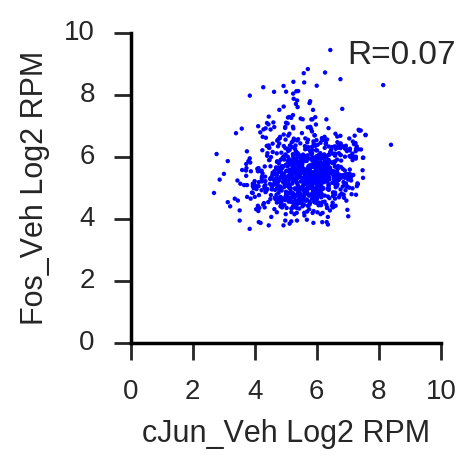

In [229]:
monomer1 = 'cJun_Veh'
monomer2 = 'Fos_Veh'
plt.figure(figsize=(2,2))
indices = summary_frame[(summary_frame['c57bl6_' + monomer1.lower()] > 0) & 
                        (summary_frame['c57bl6_' + monomer2.lower()] > 0)].index.values
x_vals = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(indices)][monomer1]
y_vals = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(indices)][monomer2]

log_x_vals = np.log2(x_vals + 1)
log_y_vals = np.log2(y_vals + 1)
with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                         }):
    plt.scatter(log_x_vals, 
                log_y_vals, 
                marker = '.', 
                s=10,
                edgecolors='none')
    
    sns.despine()
    # annotate axes 
    plt.xlabel(monomer1 + ' Log2 RPM')
    plt.ylabel(monomer2 + ' Log2 RPM')
    pearson, pearson_p = scipy.stats.pearsonr(x_vals, y_vals)
    plt.annotate(xy=(7,9), s='R='+ '{:.2f}'.format(pearson), )
    plt.xlim(0,10)
    plt.ylim(0,10)

    # Fix axes
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    
    plt.savefig('./figures/figure_01_f.svg', bbox_inches='tight')

# Figure 2 - De Novo Motif Analysis

### For overlapping dimer peaks

In [75]:
### create motif analysis directories
if not os.path.isdir('./denovo_motif_analysis'):
    os.mkdir('./denovo_motif_analysis')
else:
    ! rm -rf ./denovo_motif_analysis/*
    
if not os.path.isdir('./denovo_motif_analysis/veh_peaks'):
    os.mkdir('./denovo_motif_analysis/veh_peaks')
else:
    ! rm -rf ./denovo_motif_analysis/veh_peaks*
    
if not os.path.isdir('./denovo_motif_analysis/kla_peaks'):
    os.mkdir('./denovo_motif_analysis/kla_peaks')
else:
    ! rm -rf ./denovo_motif_analysis/kla_peaks*

In [76]:
### create peak files for denovo motif
peak_threshold = 100 # minimum number of peaks required for running motif analysis
factors = ['atf3', 'cjun','fos', 'fra1','fra2','jdp2','junb', 'jund']

treatment = 'veh'

c57bl6_columns = ['c57bl6_' + x + '_' + treatment for x in factors]
for treatment in ['veh', 'kla']:
    for i in range(len(factors)):
        factor1 = 'c57bl6_'+factors[i] + '_' + treatment
        for j in range(i, len(factors)):
            factor2 = 'c57bl6_'+ factors[j] + '_' + treatment

            if factor1 == factor2:
                outputPath = './denovo_motif_analysis/' + treatment + '_peaks/' + factor1 + '_peaks.tsv'
                current_frame = summary_frame[(summary_frame[c57bl6_columns].sum(axis=1) == summary_frame[factor1]) &
                                              (summary_frame[factor1] > 0)]
            else:
                outputPath = './denovo_motif_analysis/' + treatment + '_peaks/' + factor1 + '_' + factor2 + '_peaks.tsv'
                current_frame = summary_frame[(summary_frame[factor1]> 0) &
                                             (summary_frame[factor2] > 0)]
            current_peak_frame = current_frame[['ID', 'chr', 'start', 'end']]
            current_peak_frame['strand'] = '+'
            columns = current_peak_frame.columns.values
            columns[0]='#PeakID'        
            current_peak_frame.columns = columns
            if current_peak_frame.shape[0]  > peak_threshold:
                outputPath = outputPath.replace('c57bl6_','')
                current_peak_frame.to_csv(outputPath,
                                         index=False,
                                         sep='\t')

In [ ]:
%%bash 

if [ ! -d ./denovo_motif_analysis/veh_motif_analysis ];
    then mkdir ./denovo_motif_analysis/veh_motif_analysis_overlapping;
    mkdir ./denovo_motif_analysis/kla_motif_analysis_overlapping;
    mkdir ./denovo_motif_analysis/veh_motif_analysis_nonoverlapping;
    mkdir ./denovo_motif_analysis/kla_motif_analysis_nonoverlapping;
else

    rm -rf ./denovo_motif_analysis/*motif*/*
fi

In [ ]:
%%bash
for peakFile in ./denovo_motif_analysis/veh_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/veh_motif_analysis_overlapping/${peakName} -size 200 -len 8 -p 8 -S 3 &
    
done

for peakFile in ./denovo_motif_analysis/kla_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/kla_motif_analysis_overlapping/${peakName} -size 200 -len 8 -p 8 -S 3 &
done

In [ ]:
%%bash
if [ ! -d ./denovo_motif_analysis/top_motifs_veh_overlapping ];
    then mkdir ./denovo_motif_analysis/top_motifs_veh_overlapping;
    mkdir ./denovo_motif_analysis/top_motifs_veh_nonoverlapping;
else rm ./denovo_motif_analysis/top_motifs_veh/*/*
fi
if [ ! -d ./denovo_motif_analysis/top_motifs_kla_overlapping ];
    then mkdir ./denovo_motif_analysis/top_motifs_kla_overlapping;
    mkdir ./denovo_motif_analysis/top_motifs_kla_nonoverlapping
else rm ./denovo_motif_analysis/top_motifs_kla/*/*
fi

### For nonoverlapping dimer peaks

In [131]:
### create peak files for denovo motif analysis 
peak_threshold = 100 # minimum number of peaks required for running motif analysis

factorPairs = []
ap1_members = ['atf3','cjun', 'fra1','fra2', 'fos', 'jdp2', 'junb','jund']    
for i in range(len(ap1_members)-1):
    for j in range(i+1, len(ap1_members)):
        factorPairs.append(('c57bl6_'+ap1_members[i],'c57bl6_'+ ap1_members[j]))

c57bl6_columns = ['c57bl6_' + x + '_' + treatment for x in factors]
for treatment in ['veh', 'kla']:
    
    for i in range(len(factorPairs)-1):
        dimer1_monomer1 = factorPairs[i][0] + '_' + treatment
        dimer1_monomer2 = factorPairs[i][1] + '_' + treatment
        for j in range(i + 1, len(factorPairs)):
            dimer2_monomer1 = factorPairs[j][0] + '_' + treatment
            dimer2_monomer2 = factorPairs[j][1] + '_' + treatment
            
            outputPath = './denovo_motif_analysis/' + treatment + '_nonoverlapping_peaks/' + \
                '-'.join(factorPairs[i]).replace('c57bl6_','') + '_not_' + \
                '-'.join(factorPairs[j]).replace('c57bl6_','') + '_nonoverlapping_peaks.tsv'
#             print(dimer1_monomer1, dimer1_monomer2, dimer1_monomer2, dimer2_monomer2)
            current_frame = summary_frame[(summary_frame[dimer1_monomer1] > 0) &
                                          (summary_frame[dimer1_monomer2] > 0) &
                                          (summary_frame[dimer2_monomer1] == 0) &
                                          (summary_frame[dimer2_monomer2] == 0) ]
            current_peak_frame = current_frame[['ID', 'chr', 'start', 'end']]
            current_peak_frame['strand'] = '+'
            columns = current_peak_frame.columns.values
            columns[0]='#PeakID'        
            current_peak_frame.columns = columns
            if current_peak_frame.shape[0]  > peak_threshold:
                current_peak_frame.to_csv(outputPath,
                                         index=False,
                                         sep='\t')

In [ ]:
%%bash
for peakFile in ./denovo_motif_analysis/veh_nonoverlapping_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/veh_motif_analysis_nonoverlapping/${peakName} -size 200 -len 8 -p 8 -S 3 &
    
done

for peakFile in ./denovo_motif_analysis/kla_nonoverlapping_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/kla_motif_analysis_nonoverlapping/${peakName} -size 200 -len 8 -p 8 -S 3 &
done

In [ ]:
%%bash
# get top motif for all heterodimers


for i in ./denovo_motif_analysis/veh_motif_analysis_overlapping/*; 
do dimerName=${i##*/}
cp $i/homerResults/motif1.motif ./denovo_motif_analysis/top_motifs_veh_overlapping/${dimerName}.motif
done

for i in ./denovo_motif_analysis/kla_motif_analysis_overlapping/*; 
do dimerName=${i##*/}
cp $i/homerResults/motif1.motif ./denovo_motif_analysis/top_motifs_kla_overlapping/${dimerName}.motif
done

for i in ./denovo_motif_analysis/veh_motif_analysis_nonoverlapping/*; 
do dimerName=${i##*/}
cp $i/homerResults/motif1.motif ./denovo_motif_analysis/top_motifs_veh_nonoverlapping/${dimerName}.motif
done

for i in ./denovo_motif_analysis/kla_motif_analysis_nonoverlapping/*; 
do dimerName=${i##*/}
cp $i/homerResults/motif1.motif ./denovo_motif_analysis/top_motifs_kla_nonoverlapping/${dimerName}.motif
done

In [ ]:
%%bash
#create sequence logos for each top motif
for i in ./denovo_motif_analysis/top_motifs_veh_overlapping/*; 
do motif2Logo.pl $i
done
for i in ./denovo_motif_analysis/top_motifs_kla_overlapping/*; 
do motif2Logo.pl $i
done
for i in ./denovo_motif_analysis/top_motifs_veh_nonoverlapping/*; 
do motif2Logo.pl $i
done
for i in ./denovo_motif_analysis/top_motifs_kla_nonoverlapping/*; 
do motif2Logo.pl $i
done


### Browser shot for overlapping dimers

In [82]:
atf3_labels = summary_frame['Factors'].str.contains('c57bl6_atf3_veh')
jund_labels = summary_frame['Factors'].str.contains('c57bl6_jund_veh')

cjun_labels = summary_frame['Factors'].str.contains('c57bl6_cjun_veh')
fos_labels = summary_frame['Factors'].str.contains('c57bl6_fos_veh')

In [ ]:
summary_frame[~cjun_labels & ~fos_labels & atf3_labels & jund_labels][['chr', 'start', 'end', 
                                         'c57bl6_atf3_veh', 
                                         'c57bl6_jund_veh', 
                                         'c57bl6_cjun_veh', 
                                         'c57bl6_fos_veh']].sort('c57bl6_atf3_veh', ascending=False)

In [ ]:
summary_frame[cjun_labels & fos_labels & ~atf3_labels & ~jund_labels][['chr', 'start', 'end', 
                                         'c57bl6_atf3_veh', 
                                         'c57bl6_jund_veh', 
                                         'c57bl6_cjun_veh', 
                                         'c57bl6_fos_veh']].sort('c57bl6_atf3_veh', ascending=False)

### Browser shot for nonoverlapping dimers

In [ ]:
summary_frame[cjun_labels & fos_labels & atf3_labels & jund_labels][['chr', 'start', 'end', 
                                         'c57bl6_atf3_veh', 
                                         'c57bl6_jund_veh', 
                                         'c57bl6_cjun_veh', 
                                         'c57bl6_fos_veh']].sort('c57bl6_atf3_veh', ascending=False)

### Schematic showing top motif analysis for all overlapping dimer sites

### De novo motif analysis for non-overlapping dimer sites

### Hierarchical clustering of de-novo motifs from all heterodimers

# Figure 3 - Machine Learning Overview

### Schematic of classifier workflow

## Figure 4 - Motifs for Vehicle Dimers

In [ ]:
### for all peaks in vehicle for all motifs
numIterations = 5
factor_coeff_dict = {}
factor_auc_dict_pairs_veh = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
 
for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_veh') & summary_frame['Factors'].str.contains(factorPair[1] + '_veh')
    
    all_aucs = []
    all_coeficients = []
    for i in range(numIterations):    
        # split data into training and test sets
        training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = 0.5, tolerance = 0.01)

        #  Run classifier
        lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

        lr_classifier.fit(training_features, training_labels)
        # retreive probabilities for each classifier
        probas_lr = lr_classifier.predict_proba(test_features)
        # retrieve predictions for each classifier
        fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
        current_roc_auc = auc(fpr, tpr)
        all_aucs.append(current_roc_auc)
        
        current_coefficients = lr_classifier.coef_.flatten()
        all_coeficients.append(current_coefficients)
    mean_roc_auc = np.mean(all_aucs) # average aucROC
    mean_coefficients = np.mean(all_coeficients, axis=0) # average coefficients 
    
    factor_auc_dict_pairs_veh['_'.join(factorPair).replace('c57bl6_','')]= mean_roc_auc
    
    factor_coeff_dict['_'.join(factorPair)] = mean_coefficients
    print(factorPair, mean_roc_auc)
coefficients_frame_veh_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_veh_pairs.index = normed_motif_frame.columns.values

In [184]:
### for all peaks in vehicle for AP-1 motif
numIterations = 5
factor_auc_dict_pairs_veh_ap1 = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
 
for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)][['ap-1']]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_veh') & summary_frame['Factors'].str.contains(factorPair[1] + '_veh')
    
    all_aucs = []
    for i in range(numIterations):    
        # split data into training and test sets
        training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = 0.5, tolerance = 0.01)

        #  Run classifier
        lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

        lr_classifier.fit(training_features, training_labels)
        # retreive probabilities for each classifier
        probas_lr = lr_classifier.predict_proba(test_features)
        # retrieve predictions for each classifier
        fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
        current_roc_auc = auc(fpr, tpr)
        all_aucs.append(current_roc_auc)
        
    mean_roc_auc = np.mean(all_aucs) # average aucROC
    
    factor_auc_dict_pairs_veh_ap1['_'.join(factorPair).replace('c57bl6_','')]= mean_roc_auc
    print(factorPair, mean_roc_auc)


('c57bl6_atf3', 'c57bl6_cjun') 0.713185910599
('c57bl6_atf3', 'c57bl6_fra1') 0.715895928648
('c57bl6_atf3', 'c57bl6_fra2') 0.755093747672
('c57bl6_atf3', 'c57bl6_fos') 0.811804280005
('c57bl6_atf3', 'c57bl6_jdp2') 0.742031647918
('c57bl6_atf3', 'c57bl6_junb') 0.764178332039
('c57bl6_atf3', 'c57bl6_jund') 0.722548604512
('c57bl6_cjun', 'c57bl6_fra1') 0.677194257053
('c57bl6_cjun', 'c57bl6_fra2') 0.7358609644
('c57bl6_cjun', 'c57bl6_fos') 0.772364974057
('c57bl6_cjun', 'c57bl6_jdp2') 0.719155122021
('c57bl6_cjun', 'c57bl6_junb') 0.724083304798
('c57bl6_cjun', 'c57bl6_jund') 0.684320387666
('c57bl6_fra1', 'c57bl6_fra2') 0.679727372319
('c57bl6_fra1', 'c57bl6_fos') 0.757372448789
('c57bl6_fra1', 'c57bl6_jdp2') 0.734991622189
('c57bl6_fra1', 'c57bl6_junb') 0.698170059686
('c57bl6_fra1', 'c57bl6_jund') 0.634312112371
('c57bl6_fra2', 'c57bl6_fos') 0.812745535594
('c57bl6_fra2', 'c57bl6_jdp2') 0.74090217119
('c57bl6_fra2', 'c57bl6_junb') 0.751548684995
('c57bl6_fra2', 'c57bl6_jund') 0.70613845

In [176]:
### for all peaks in vehicle for top motifs
weight_threshold = 0.5
numIterations = 5
factor_auc_dict_pairs_veh_top = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
 
for factorPair in factorPairs:
    # retreive top motifs for factor pair
    top_motifs = coefficients_frame_veh_pairs[
        coefficients_frame_veh_pairs['_'.join(factorPair)].abs() >= weight_threshold].index.values
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)][top_motifs] 
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_veh') & summary_frame['Factors'].str.contains(factorPair[1] + '_veh')
    all_aucs = []
    for i in range(numIterations):    
        # split data into training and test sets
        training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = 0.5, tolerance = 0.01)

        #  Run classifier
        lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

        lr_classifier.fit(training_features, training_labels)
        # retreive probabilities for each classifier
        probas_lr = lr_classifier.predict_proba(test_features)
        # retrieve predictions for each classifier
        fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
        current_roc_auc = auc(fpr, tpr)
        all_aucs.append(current_roc_auc)
        
    mean_roc_auc = np.mean(all_aucs) # average aucROC
    
    factor_auc_dict_pairs_veh_top['_'.join(factorPair).replace('c57bl6_','')]= mean_roc_auc
    
    print(factorPair, mean_roc_auc)

('c57bl6_atf3', 'c57bl6_cjun') 0.804780680271
('c57bl6_atf3', 'c57bl6_fra1') 0.838475894978
('c57bl6_atf3', 'c57bl6_fra2') 0.84100837785
('c57bl6_atf3', 'c57bl6_fos') 0.891377026288
('c57bl6_atf3', 'c57bl6_jdp2') 0.84683852875
('c57bl6_atf3', 'c57bl6_junb') 0.857192708263
('c57bl6_atf3', 'c57bl6_jund') 0.839291410896
('c57bl6_cjun', 'c57bl6_fra1') 0.803619292584
('c57bl6_cjun', 'c57bl6_fra2') 0.825284175408
('c57bl6_cjun', 'c57bl6_fos') 0.871414433084
('c57bl6_cjun', 'c57bl6_jdp2') 0.840407512721
('c57bl6_cjun', 'c57bl6_junb') 0.842646382065
('c57bl6_cjun', 'c57bl6_jund') 0.802320959027
('c57bl6_fra1', 'c57bl6_fra2') 0.81039035273
('c57bl6_fra1', 'c57bl6_fos') 0.875507397648
('c57bl6_fra1', 'c57bl6_jdp2') 0.839242034383
('c57bl6_fra1', 'c57bl6_junb') 0.848487692105
('c57bl6_fra1', 'c57bl6_jund') 0.794973498938
('c57bl6_fra2', 'c57bl6_fos') 0.893609637779
('c57bl6_fra2', 'c57bl6_jdp2') 0.854156529549
('c57bl6_fra2', 'c57bl6_junb') 0.836465315381
('c57bl6_fra2', 'c57bl6_jund') 0.80778775

### Classifier Performance

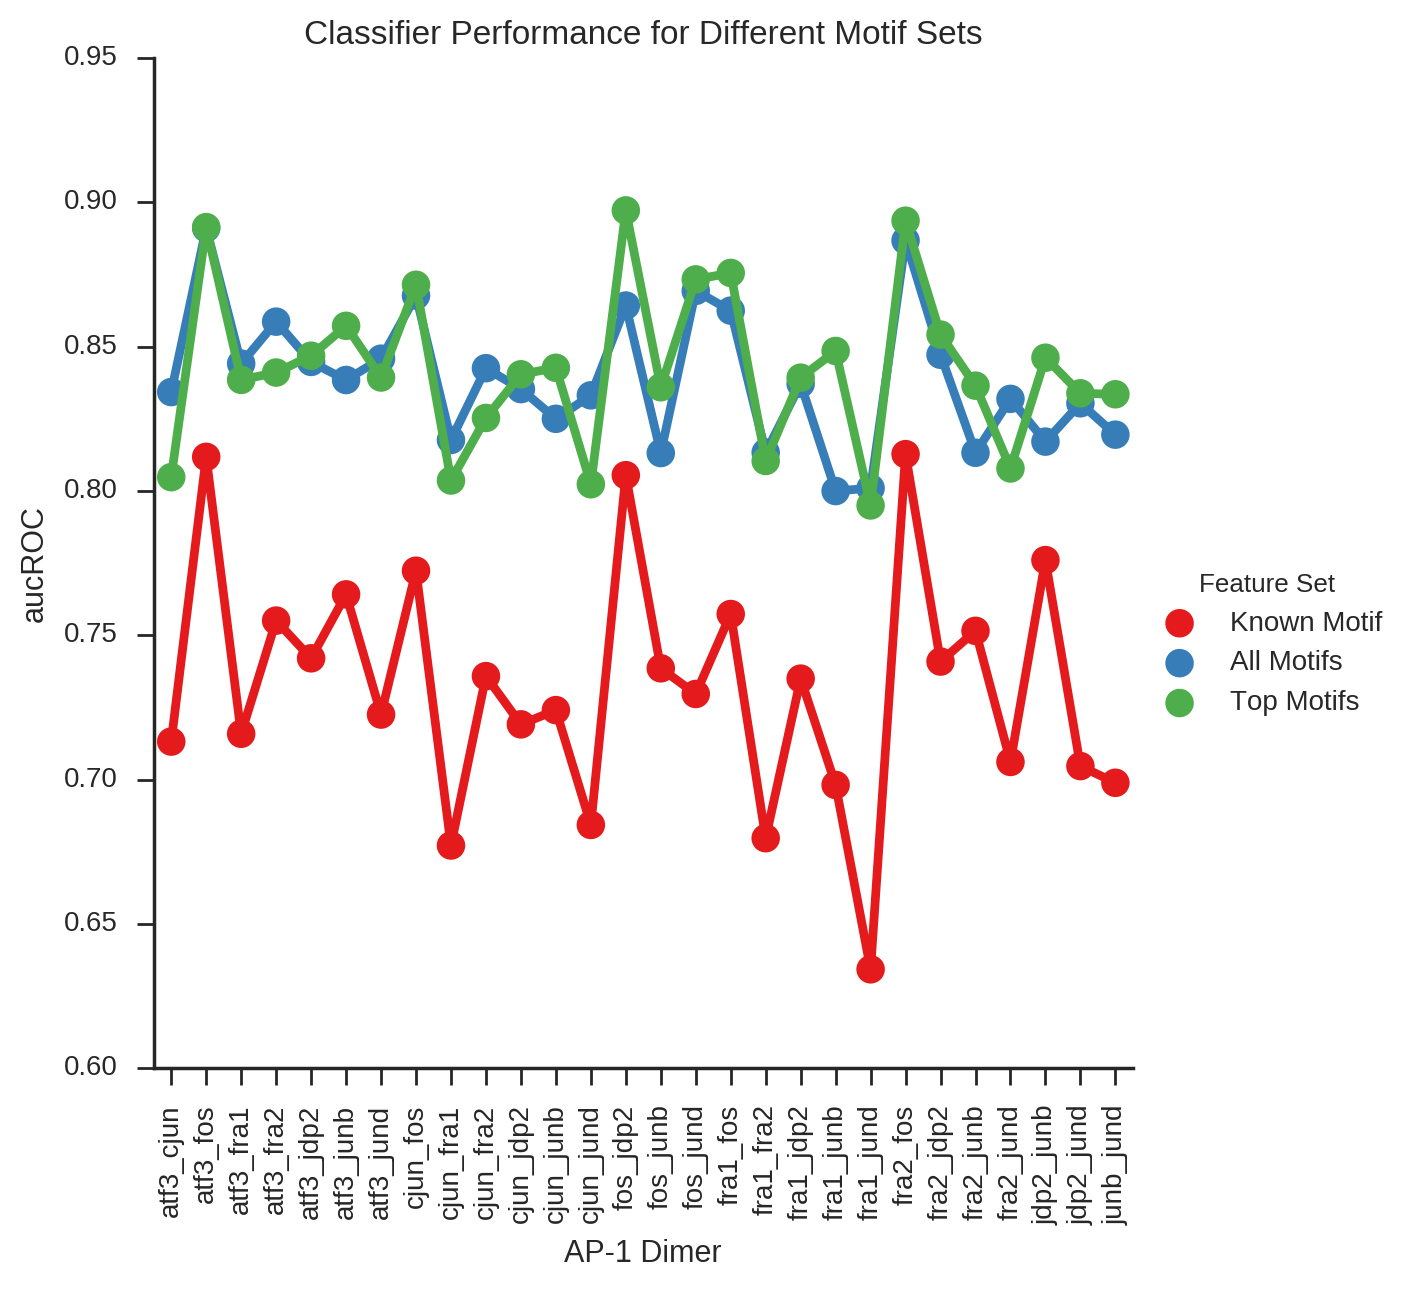

In [206]:
factors = []
aucs = []
features = []
for factor in sorted(factor_auc_dict_pairs_veh.keys()):
    factors = factors + 3 * [factor]
    features = features + ['Known Motif', 'All Motifs', 'Top Motifs']
    aucs.append(factor_auc_dict_pairs_veh_ap1[factor])
    aucs.append(factor_auc_dict_pairs_veh[factor])
    aucs.append(factor_auc_dict_pairs_veh_top[factor])
    
with sns.axes_style('ticks'):
    plottingFrame = sns.factorplot(data = pd.DataFrame({'Factor':factors,
                                                         'AUC':aucs,
                                                         'Feature Set':features}),
                                x='Factor',
                                y='AUC',
                                hue='Feature Set',
                                palette='Set1',
                                size=6)
    sns.despine()
    plt.xticks(rotation=90)
    plt.ylabel('aucROC')
    plt.xlabel('AP-1 Dimer')
#     plt.ylim(0.5,1)
    plt.title('Classifier Performance for Different Motif Sets')
    plt.savefig('/home/jenhan/analysis/cobinding_motif_analysis/figures/figure_04_a.svg', bbox_inches='tight')

### Distribution of Motif Weights (for cjun-fos, or all dimers?)

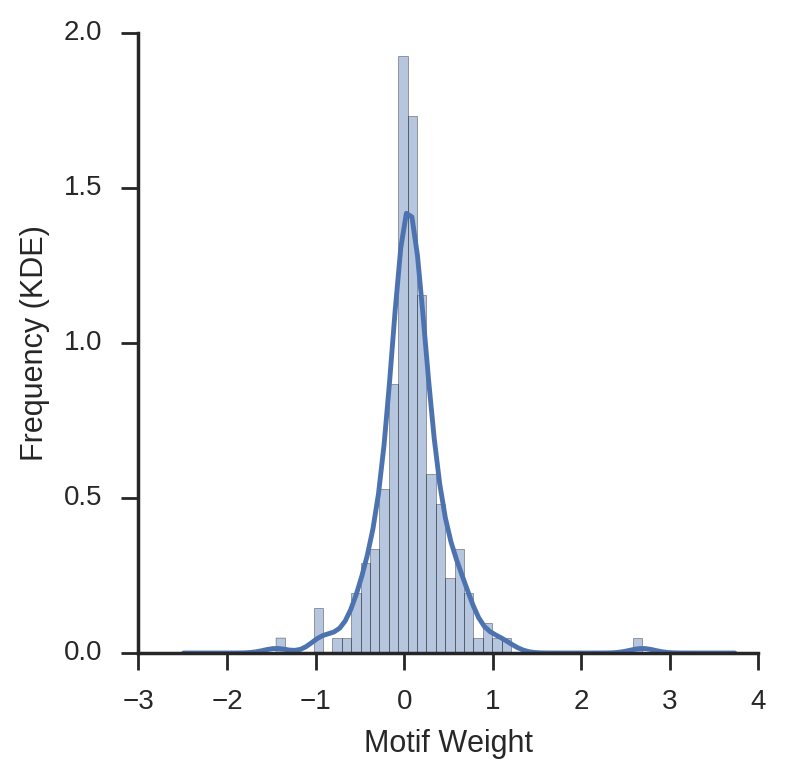

In [228]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(4,4))
    sns.distplot(coefficients_frame_veh_pairs['c57bl6_cjun_c57bl6_fos'])
    sns.despine()
    plt.xlabel('Motif Weight')
    plt.ylabel('Frequency (KDE)')
plt.savefig('./figures/figure_04_b.svg', bbox_inches='tight')

### Scatter plot for similar dimers

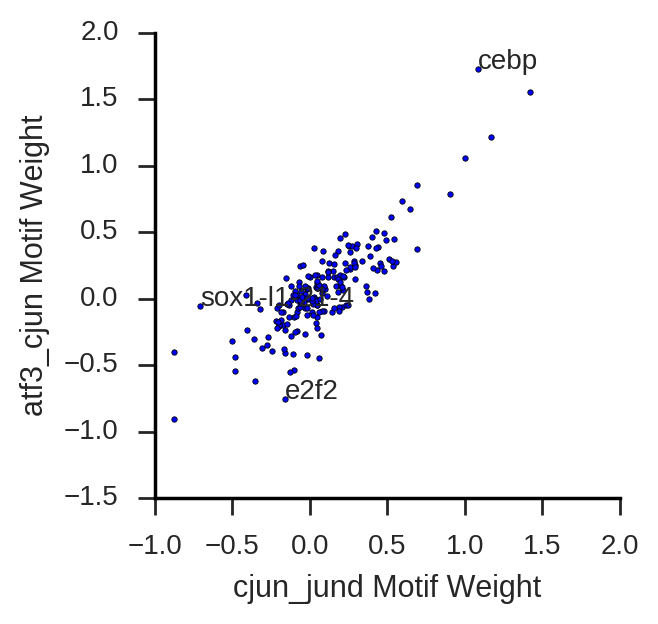

In [227]:
# scatterplot of weights
factor1 = 'c57bl6_cjun_c57bl6_jund'
factor2 = 'c57bl6_atf3_c57bl6_cjun'
delta_threshold = 0.5
targets = []
plt.figure(figsize=(3,3))
motifs = coefficients_frame_veh_pairs.index.values
with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                         }):
    x_vals = coefficients_frame_veh_pairs[factor1]
    y_vals = coefficients_frame_veh_pairs[factor2]
    # calculate colors
    plt.scatter(x_vals,
                y_vals,
                marker = '.', 
                s=15)
    plt.xlabel(factor1.replace('c57bl6_','') + ' Motif Weight')
    plt.ylabel(factor2.replace('c57bl6_','') + ' Motif Weight')
    sns.despine()
    

    # calculate labels
    for i in range(len(x_vals)):
        x = x_vals[i]
        y = y_vals[i]
        if abs(x) >= 0.5 or abs(y) >= 0.5:
            delta = np.max([y_vals[i], x_vals[i]]) - np.min([y_vals[i], x_vals[i]])
            if delta > delta_threshold or motifs[i] in targets:
                plt.annotate(motifs[i], xy=(x,y) , size=10)
                    
    # Fix axes
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
plt.savefig('./figures/figure_04_c.svg', bbox_inches='tight')

### Scatter plot for dissimilar dimers

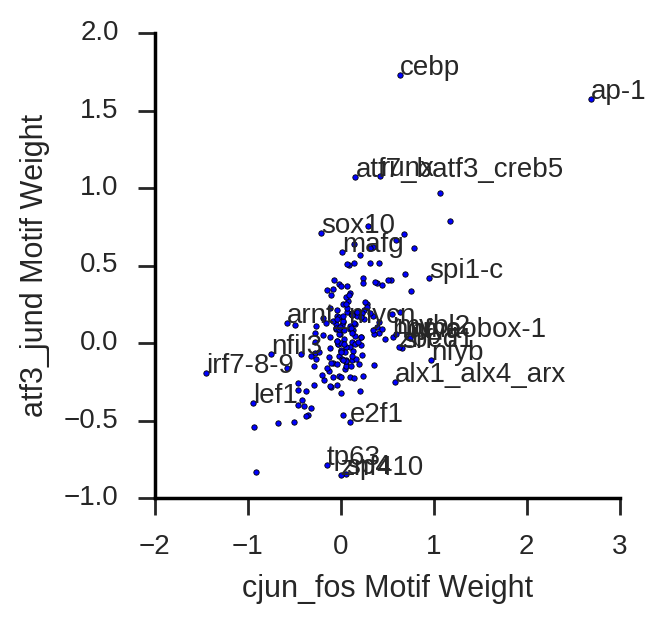

In [226]:
# scatterplot of weights
factor1 = 'c57bl6_cjun_c57bl6_fos'
factor2 = 'c57bl6_atf3_c57bl6_jund'
delta_threshold = 0.5
targets = ['ap-1, cebp', 'spi1-c', 'ctcf', 'irf1']
targets = []
plt.figure(figsize=(3,3))
motifs = coefficients_frame_veh_pairs.index.values
with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                         }):
    x_vals = coefficients_frame_veh_pairs[factor1]
    y_vals = coefficients_frame_veh_pairs[factor2]
    # calculate colors
    plt.scatter(x_vals,
                y_vals,
                marker = '.', 
                s=15)
    plt.xlabel(factor1.replace('c57bl6_','') + ' Motif Weight')
    plt.ylabel(factor2.replace('c57bl6_','') + ' Motif Weight')
    sns.despine()
    

    # calculate labels
    for i in range(len(x_vals)):
        x = x_vals[i]
        y = y_vals[i]
        if abs(x) >= 0.5 or abs(y) >= 0.5:
            delta = np.max([y_vals[i], x_vals[i]]) - np.min([y_vals[i], x_vals[i]])
            if delta > delta_threshold or motifs[i] in targets:
                plt.annotate(motifs[i], xy=(x,y) , size=10)
                    
    # Fix axes
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
plt.savefig('./figures/figure_04_d.svg', bbox_inches='tight')


### Heatmap of all vehicle dimer weights

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/seaborn-0.7.0-py3.4.egg/seaborn/matrix.py:134: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


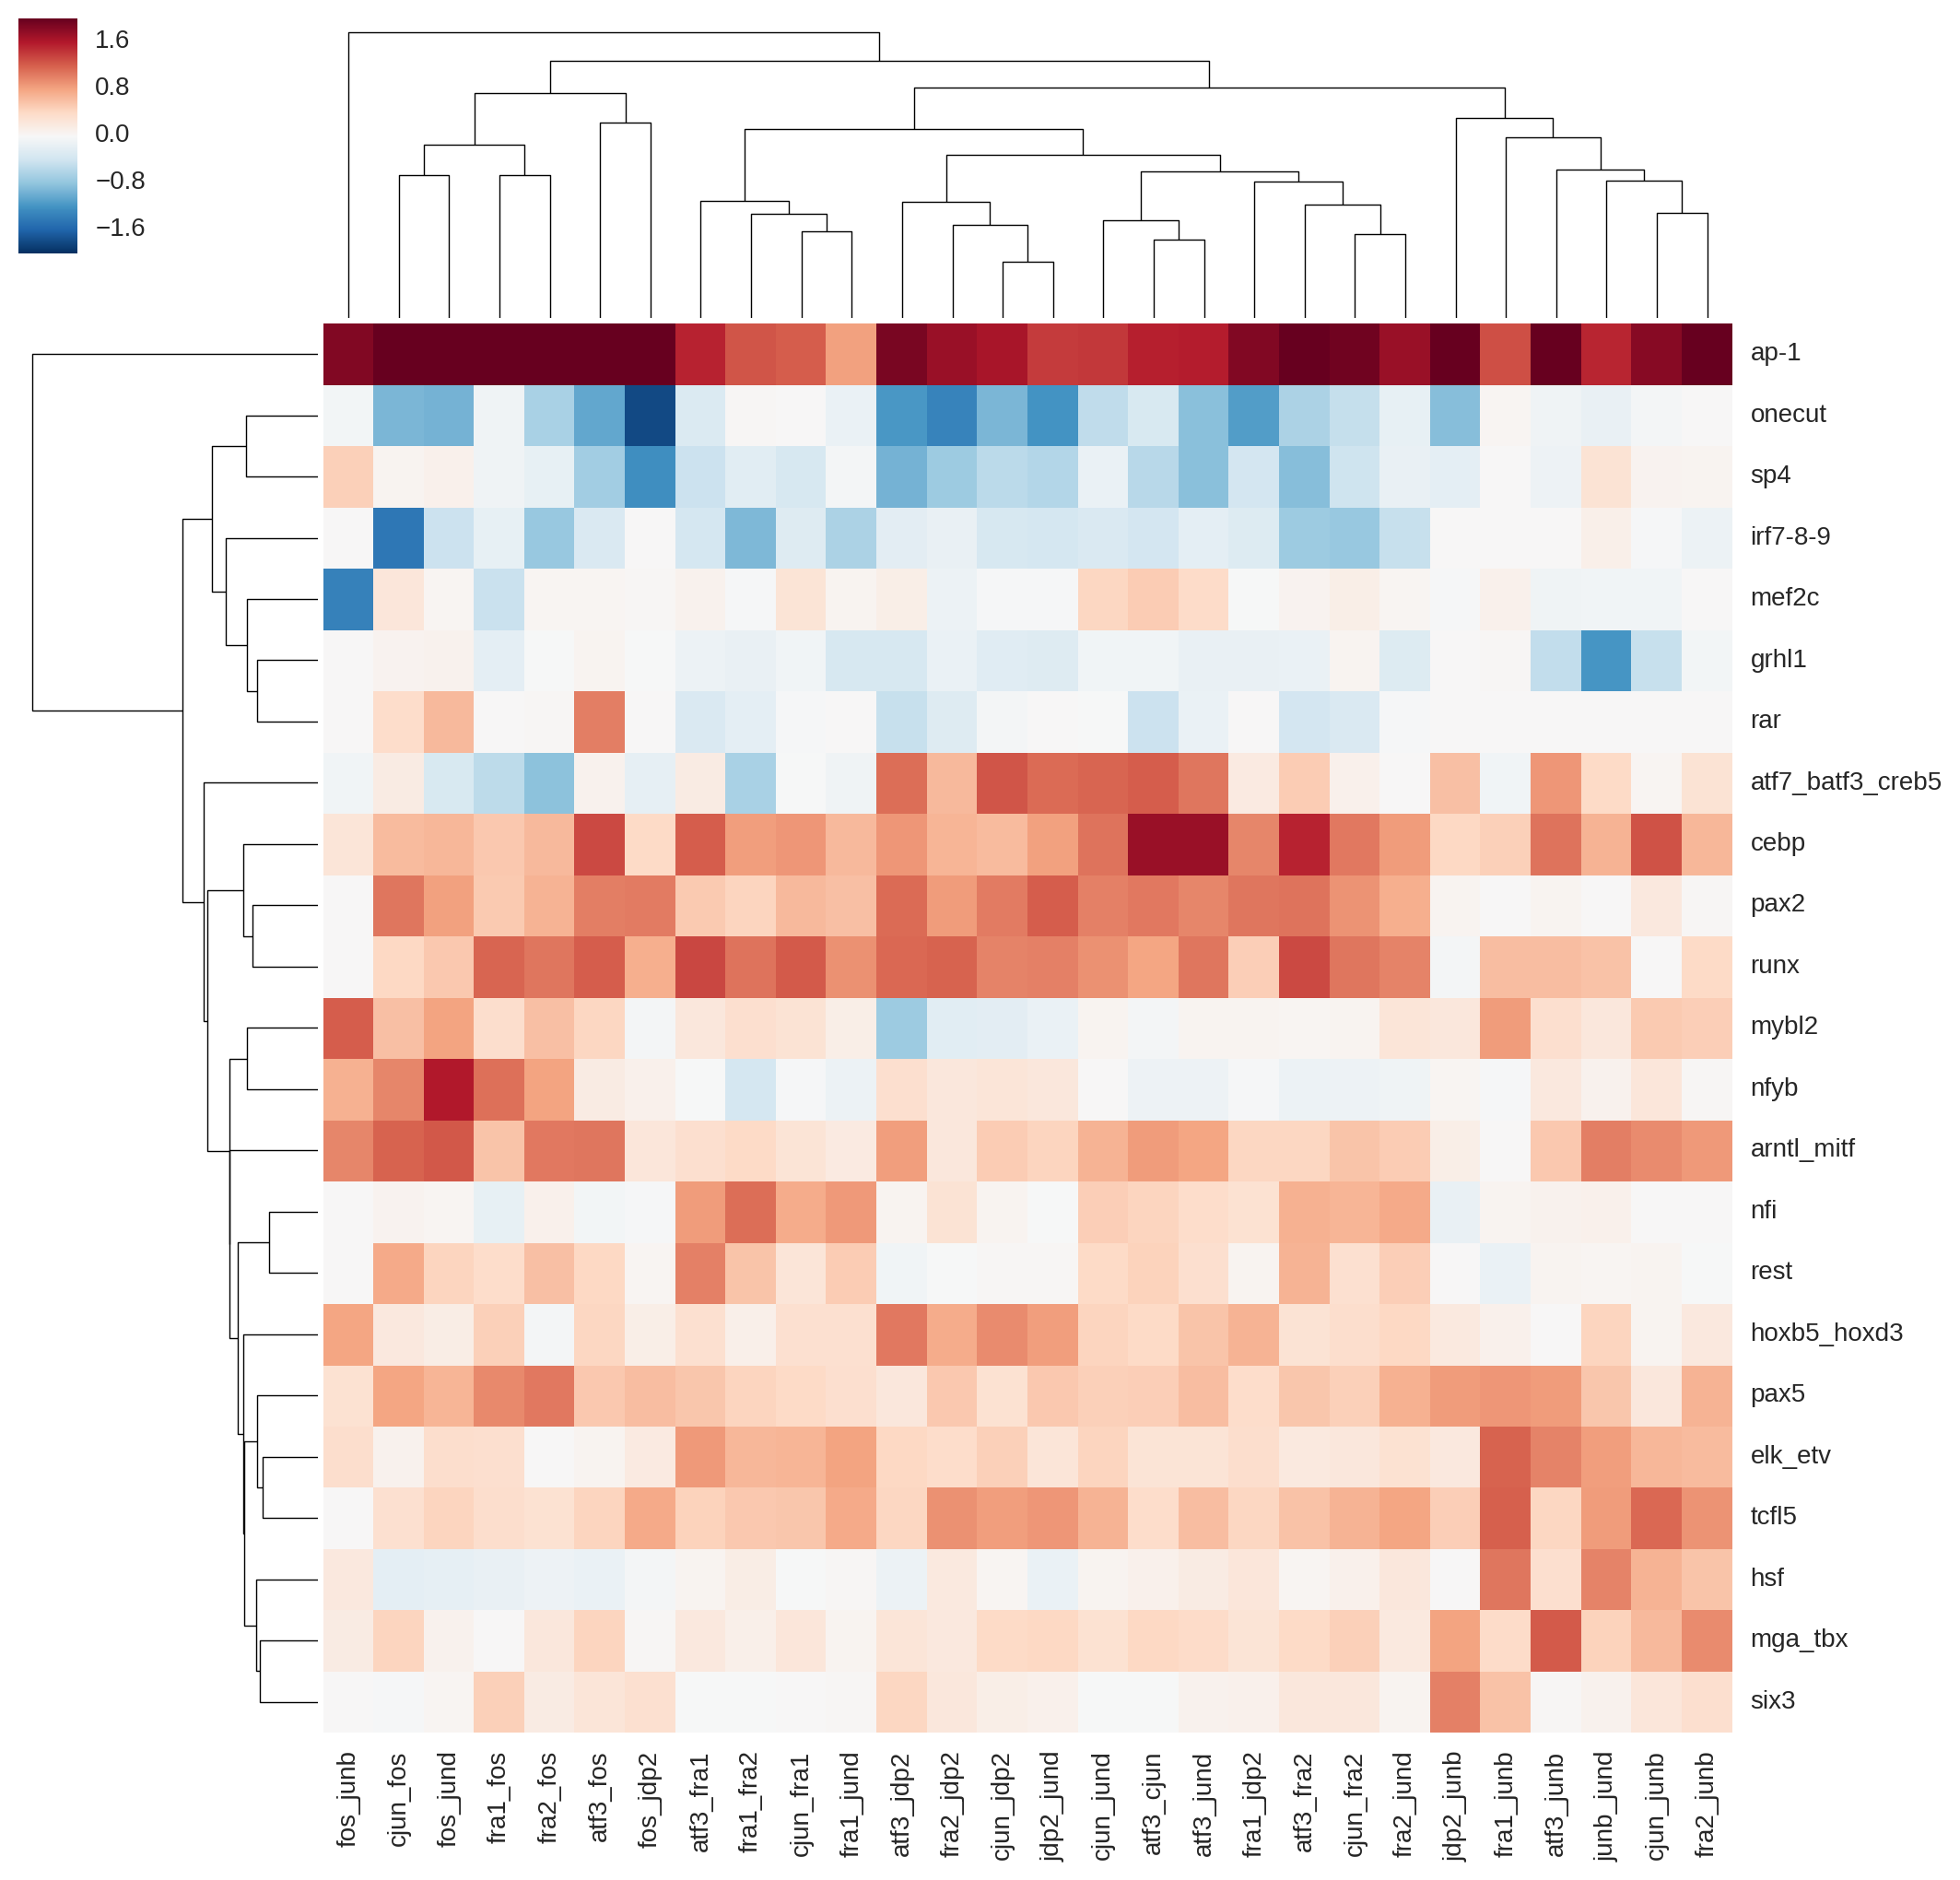

In [225]:
### plot coefficents for vehicle
weight_threshold = 1.0

cg = sns.clustermap(coefficients_frame_veh_pairs[(coefficients_frame_veh_pairs.max(axis=1) >= weight_threshold) |
                                       (coefficients_frame_veh_pairs.min(axis=1) < -1 * weight_threshold)
                                      ],
                   vmax=-2,
                   vmin=2,
                   center = 0.0,
#                    annot=True,annot_kws={"size": 4},
                   figsize=(12,12),
                   xticklabels=[x.replace('c57bl6_','') for x in coefficients_frame_veh_pairs.columns.values])
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);
plt.savefig('./figures/figure_04_e.svg', bbox_inches='tight')

# Figure 5 - Context Change after KLA treatment

In [ ]:
### for all peaks in klaicle for all motifs
numIterations = 5
factor_coeff_dict = {}
factor_auc_dict_pairs_kla = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
 
for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_kla') & summary_frame['Factors'].str.contains(factorPair[1] + '_kla')
    
    all_aucs = []
    all_coeficients = []
    for i in range(numIterations):    
        # split data into training and test sets
        training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = 0.5, tolerance = 0.01)

        #  Run classifier
        lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

        lr_classifier.fit(training_features, training_labels)
        # retreive probabilities for each classifier
        probas_lr = lr_classifier.predict_proba(test_features)
        # retrieve predictions for each classifier
        fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
        current_roc_auc = auc(fpr, tpr)
        all_aucs.append(current_roc_auc)
        
        current_coefficients = lr_classifier.coef_.flatten()
        all_coeficients.append(current_coefficients)
    mean_roc_auc = np.mean(all_aucs) # average aucROC
    mean_coefficients = np.mean(all_coeficients, axis=0) # average coefficients 
    
    factor_auc_dict_pairs_kla['_'.join(factorPair).replace('c57bl6_','')]= mean_roc_auc
    
    factor_coeff_dict['_'.join(factorPair)] = mean_coefficients
    print(factorPair, mean_roc_auc)
coefficients_frame_kla_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_kla_pairs.index = normed_motif_frame.columns.values

In [218]:
### for all peaks in klaicle for AP-1 motif
numIterations = 5
factor_auc_dict_pairs_kla_ap1 = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
 
for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)][['ap-1']]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_kla') & summary_frame['Factors'].str.contains(factorPair[1] + '_kla')
    
    all_aucs = []
    for i in range(numIterations):    
        # split data into training and test sets
        training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = 0.5, tolerance = 0.01)

        #  Run classifier
        lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

        lr_classifier.fit(training_features, training_labels)
        # retreive probabilities for each classifier
        probas_lr = lr_classifier.predict_proba(test_features)
        # retrieve predictions for each classifier
        fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
        current_roc_auc = auc(fpr, tpr)
        all_aucs.append(current_roc_auc)
        
    mean_roc_auc = np.mean(all_aucs) # average aucROC
    
    factor_auc_dict_pairs_kla_ap1['_'.join(factorPair).replace('c57bl6_','')]= mean_roc_auc
    print(factorPair, mean_roc_auc)



('c57bl6_atf3', 'c57bl6_cjun') 0.721514910985
('c57bl6_atf3', 'c57bl6_fra1') 0.72382614982
('c57bl6_atf3', 'c57bl6_fra2') 0.752101952242
('c57bl6_atf3', 'c57bl6_fos') 0.739708296257
('c57bl6_atf3', 'c57bl6_jdp2') 0.74010901406
('c57bl6_atf3', 'c57bl6_junb') 0.743128352888
('c57bl6_atf3', 'c57bl6_jund') 0.720561624739
('c57bl6_cjun', 'c57bl6_fra1') 0.69835101032
('c57bl6_cjun', 'c57bl6_fra2') 0.745749851175
('c57bl6_cjun', 'c57bl6_fos') 0.746256353691
('c57bl6_cjun', 'c57bl6_jdp2') 0.739872619517
('c57bl6_cjun', 'c57bl6_junb') 0.74486137709
('c57bl6_cjun', 'c57bl6_jund') 0.712104892622
('c57bl6_fra1', 'c57bl6_fra2') 0.737009451346
('c57bl6_fra1', 'c57bl6_fos') 0.716119352492
('c57bl6_fra1', 'c57bl6_jdp2') 0.781592946593
('c57bl6_fra1', 'c57bl6_junb') 0.727660020495
('c57bl6_fra1', 'c57bl6_jund') 0.689384617148
('c57bl6_fra2', 'c57bl6_fos') 0.755687931947
('c57bl6_fra2', 'c57bl6_jdp2') 0.772006214683
('c57bl6_fra2', 'c57bl6_junb') 0.76138593937
('c57bl6_fra2', 'c57bl6_jund') 0.7418654545

In [219]:
### for all peaks in kla for top motifs
weight_threshold = 0.5
numIterations = 5
factor_auc_dict_pairs_kla_top = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
 
for factorPair in factorPairs:
    # retreive top motifs for factor pair
    top_motifs = coefficients_frame_kla_pairs[
        coefficients_frame_kla_pairs['_'.join(factorPair)].abs() >= weight_threshold].index.values
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)][top_motifs] 
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_kla') & summary_frame['Factors'].str.contains(factorPair[1] + '_kla')
    all_aucs = []
    for i in range(numIterations):    
        # split data into training and test sets
        training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = 0.5, tolerance = 0.01)

        #  Run classifier
        lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

        lr_classifier.fit(training_features, training_labels)
        # retreive probabilities for each classifier
        probas_lr = lr_classifier.predict_proba(test_features)
        # retrieve predictions for each classifier
        fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
        current_roc_auc = auc(fpr, tpr)
        all_aucs.append(current_roc_auc)
        
    mean_roc_auc = np.mean(all_aucs) # average aucROC
    
    factor_auc_dict_pairs_kla_top['_'.join(factorPair).replace('c57bl6_','')]= mean_roc_auc
    
    print(factorPair, mean_roc_auc)

('c57bl6_atf3', 'c57bl6_cjun') 0.803062246186
('c57bl6_atf3', 'c57bl6_fra1') 0.843873851569
('c57bl6_atf3', 'c57bl6_fra2') 0.821425281479
('c57bl6_atf3', 'c57bl6_fos') 0.810591404157
('c57bl6_atf3', 'c57bl6_jdp2') 0.82590474055
('c57bl6_atf3', 'c57bl6_junb') 0.827075037671
('c57bl6_atf3', 'c57bl6_jund') 0.799845079023
('c57bl6_cjun', 'c57bl6_fra1') 0.817476938793
('c57bl6_cjun', 'c57bl6_fra2') 0.816501041179
('c57bl6_cjun', 'c57bl6_fos') 0.81306890732
('c57bl6_cjun', 'c57bl6_jdp2') 0.820428972332
('c57bl6_cjun', 'c57bl6_junb') 0.828610312968
('c57bl6_cjun', 'c57bl6_jund') 0.797683863571
('c57bl6_fra1', 'c57bl6_fra2') 0.845904572854
('c57bl6_fra1', 'c57bl6_fos') 0.828891725094
('c57bl6_fra1', 'c57bl6_jdp2') 0.866963242227
('c57bl6_fra1', 'c57bl6_junb') 0.836646047322
('c57bl6_fra1', 'c57bl6_jund') 0.81220563064
('c57bl6_fra2', 'c57bl6_fos') 0.81343015584
('c57bl6_fra2', 'c57bl6_jdp2') 0.846128912602
('c57bl6_fra2', 'c57bl6_junb') 0.83256560043
('c57bl6_fra2', 'c57bl6_jund') 0.8067502196

### Classifier Performance

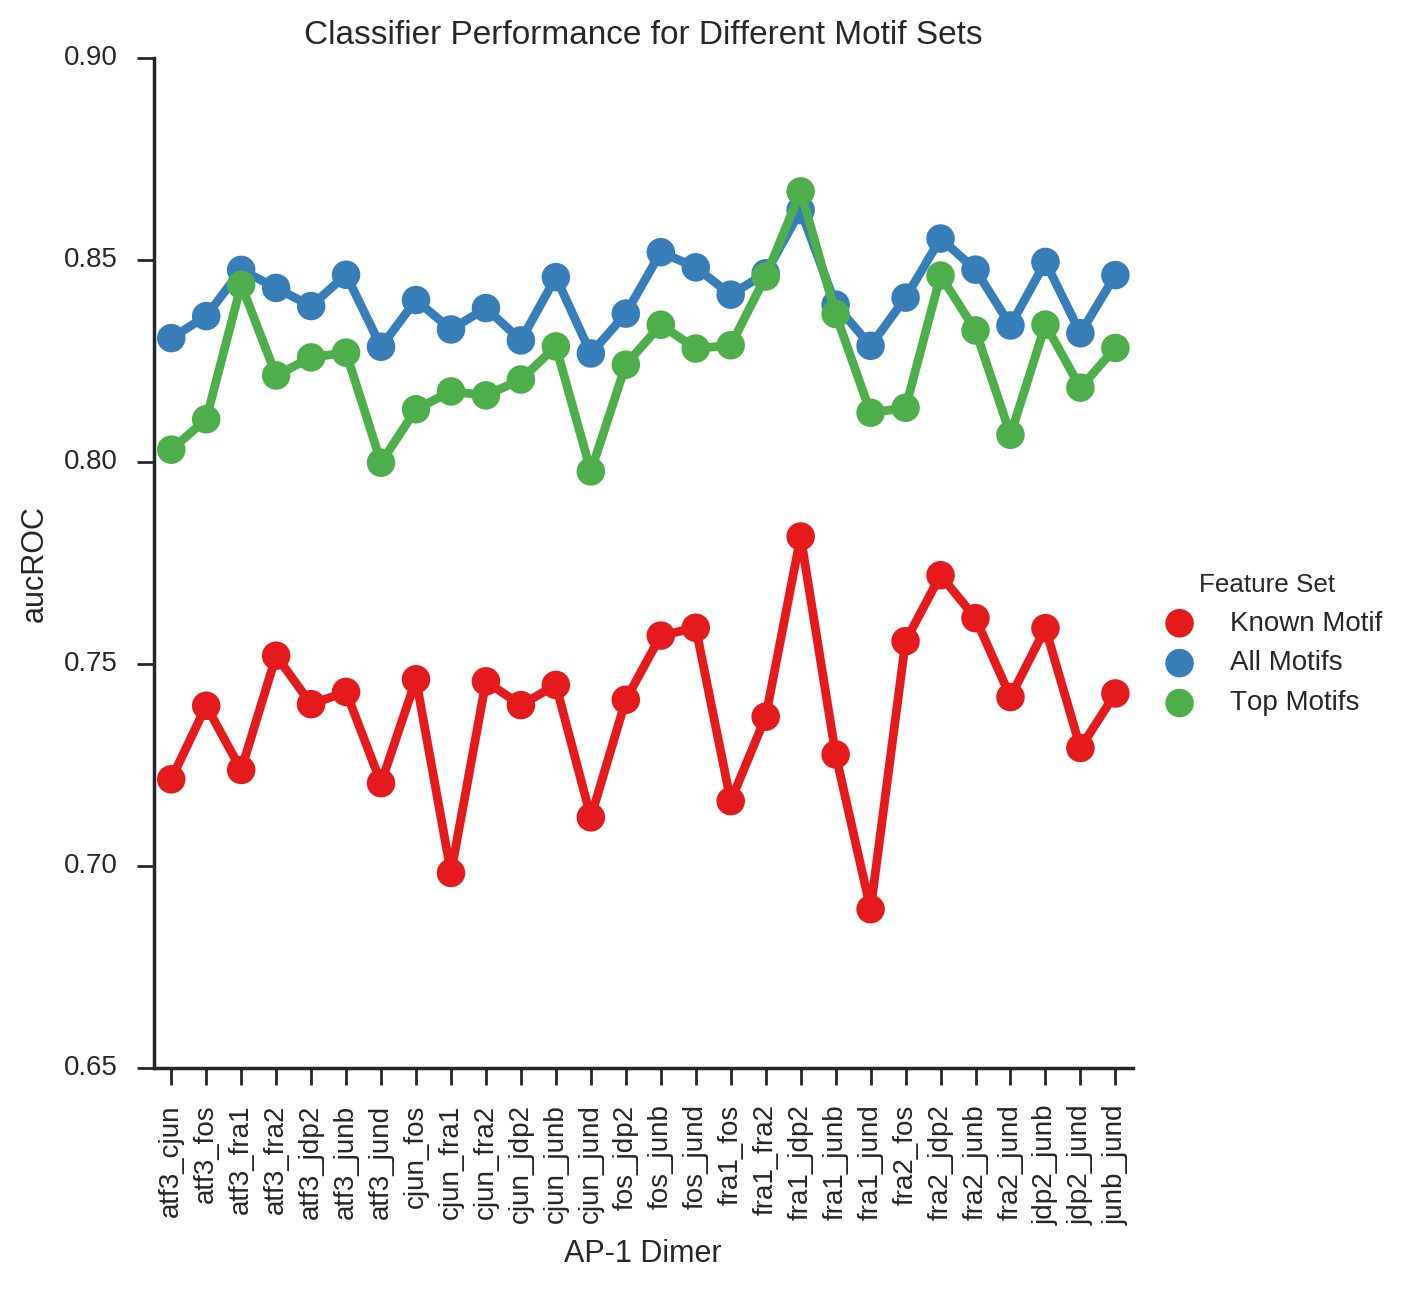

In [220]:
factors = []
aucs = []
features = []
for factor in sorted(factor_auc_dict_pairs_kla.keys()):
    factors = factors + 3 * [factor]
    features = features + ['Known Motif', 'All Motifs', 'Top Motifs']
    aucs.append(factor_auc_dict_pairs_kla_ap1[factor])
    aucs.append(factor_auc_dict_pairs_kla[factor])
    aucs.append(factor_auc_dict_pairs_kla_top[factor])
    
with sns.axes_style('ticks'):
    plottingFrame = sns.factorplot(data = pd.DataFrame({'Factor':factors,
                                                         'AUC':aucs,
                                                         'Feature Set':features}),
                                x='Factor',
                                y='AUC',
                                hue='Feature Set',
                                palette='Set1',
                                size=6)
    sns.despine()
    plt.xticks(rotation=90)
    plt.ylabel('aucROC')
    plt.xlabel('AP-1 Dimer')
#     plt.ylim(0.5,1)
    plt.title('Classifier Performance for Different Motif Sets')
    plt.savefig('/home/jenhan/analysis/cobinding_motif_analysis/figures/figure_05_a.svg', bbox_inches='tight')

### Scatter plot for all cjun-jund motif weights before and after Vehicle

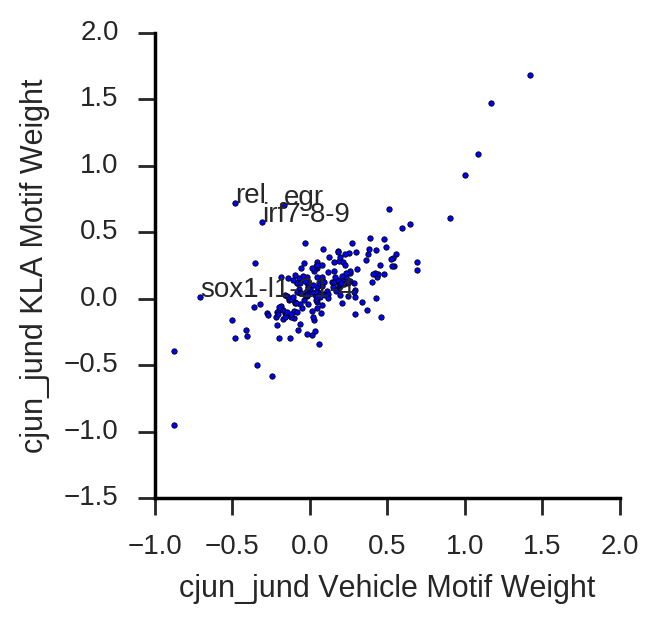

In [224]:
# scatterplot of weights
factor1 = 'c57bl6_cjun_c57bl6_jund'
factor2 = 'c57bl6_cjun_c57bl6_jund'
delta_threshold = 0.5
targets = ['ap-1, cebp', 'spi1-c', 'ctcf', 'irf1', 'rel']
# targets = []
plt.figure(figsize=(3,3))
motifs = coefficients_frame_veh_pairs.index.values
with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                         }):
    x_vals = coefficients_frame_veh_pairs[factor1]
    y_vals = coefficients_frame_kla_pairs[factor2]
    # calculate colors
    plt.scatter(x_vals,
                y_vals,
                marker = '.', 
                s=15)
    plt.xlabel(factor1.replace('c57bl6_','') + ' Vehicle Motif Weight')
    plt.ylabel(factor2.replace('c57bl6_','') + ' KLA Motif Weight')
    sns.despine()
    

    # calculate labels
    for i in range(len(x_vals)):
        x = x_vals[i]
        y = y_vals[i]
        if abs(x) >= 0.5 or abs(y) >= 0.5:
            delta = np.max([y_vals[i], x_vals[i]]) - np.min([y_vals[i], x_vals[i]])
            if delta > delta_threshold or motifs[i] in targets:
                plt.annotate(motifs[i], xy=(x,y) , size=10)
                    
    # Fix axes
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
plt.savefig('./figures/figure_05_b.svg', bbox_inches='tight')


### Heatmap for all KLA dimer weights

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/seaborn-0.7.0-py3.4.egg/seaborn/matrix.py:134: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


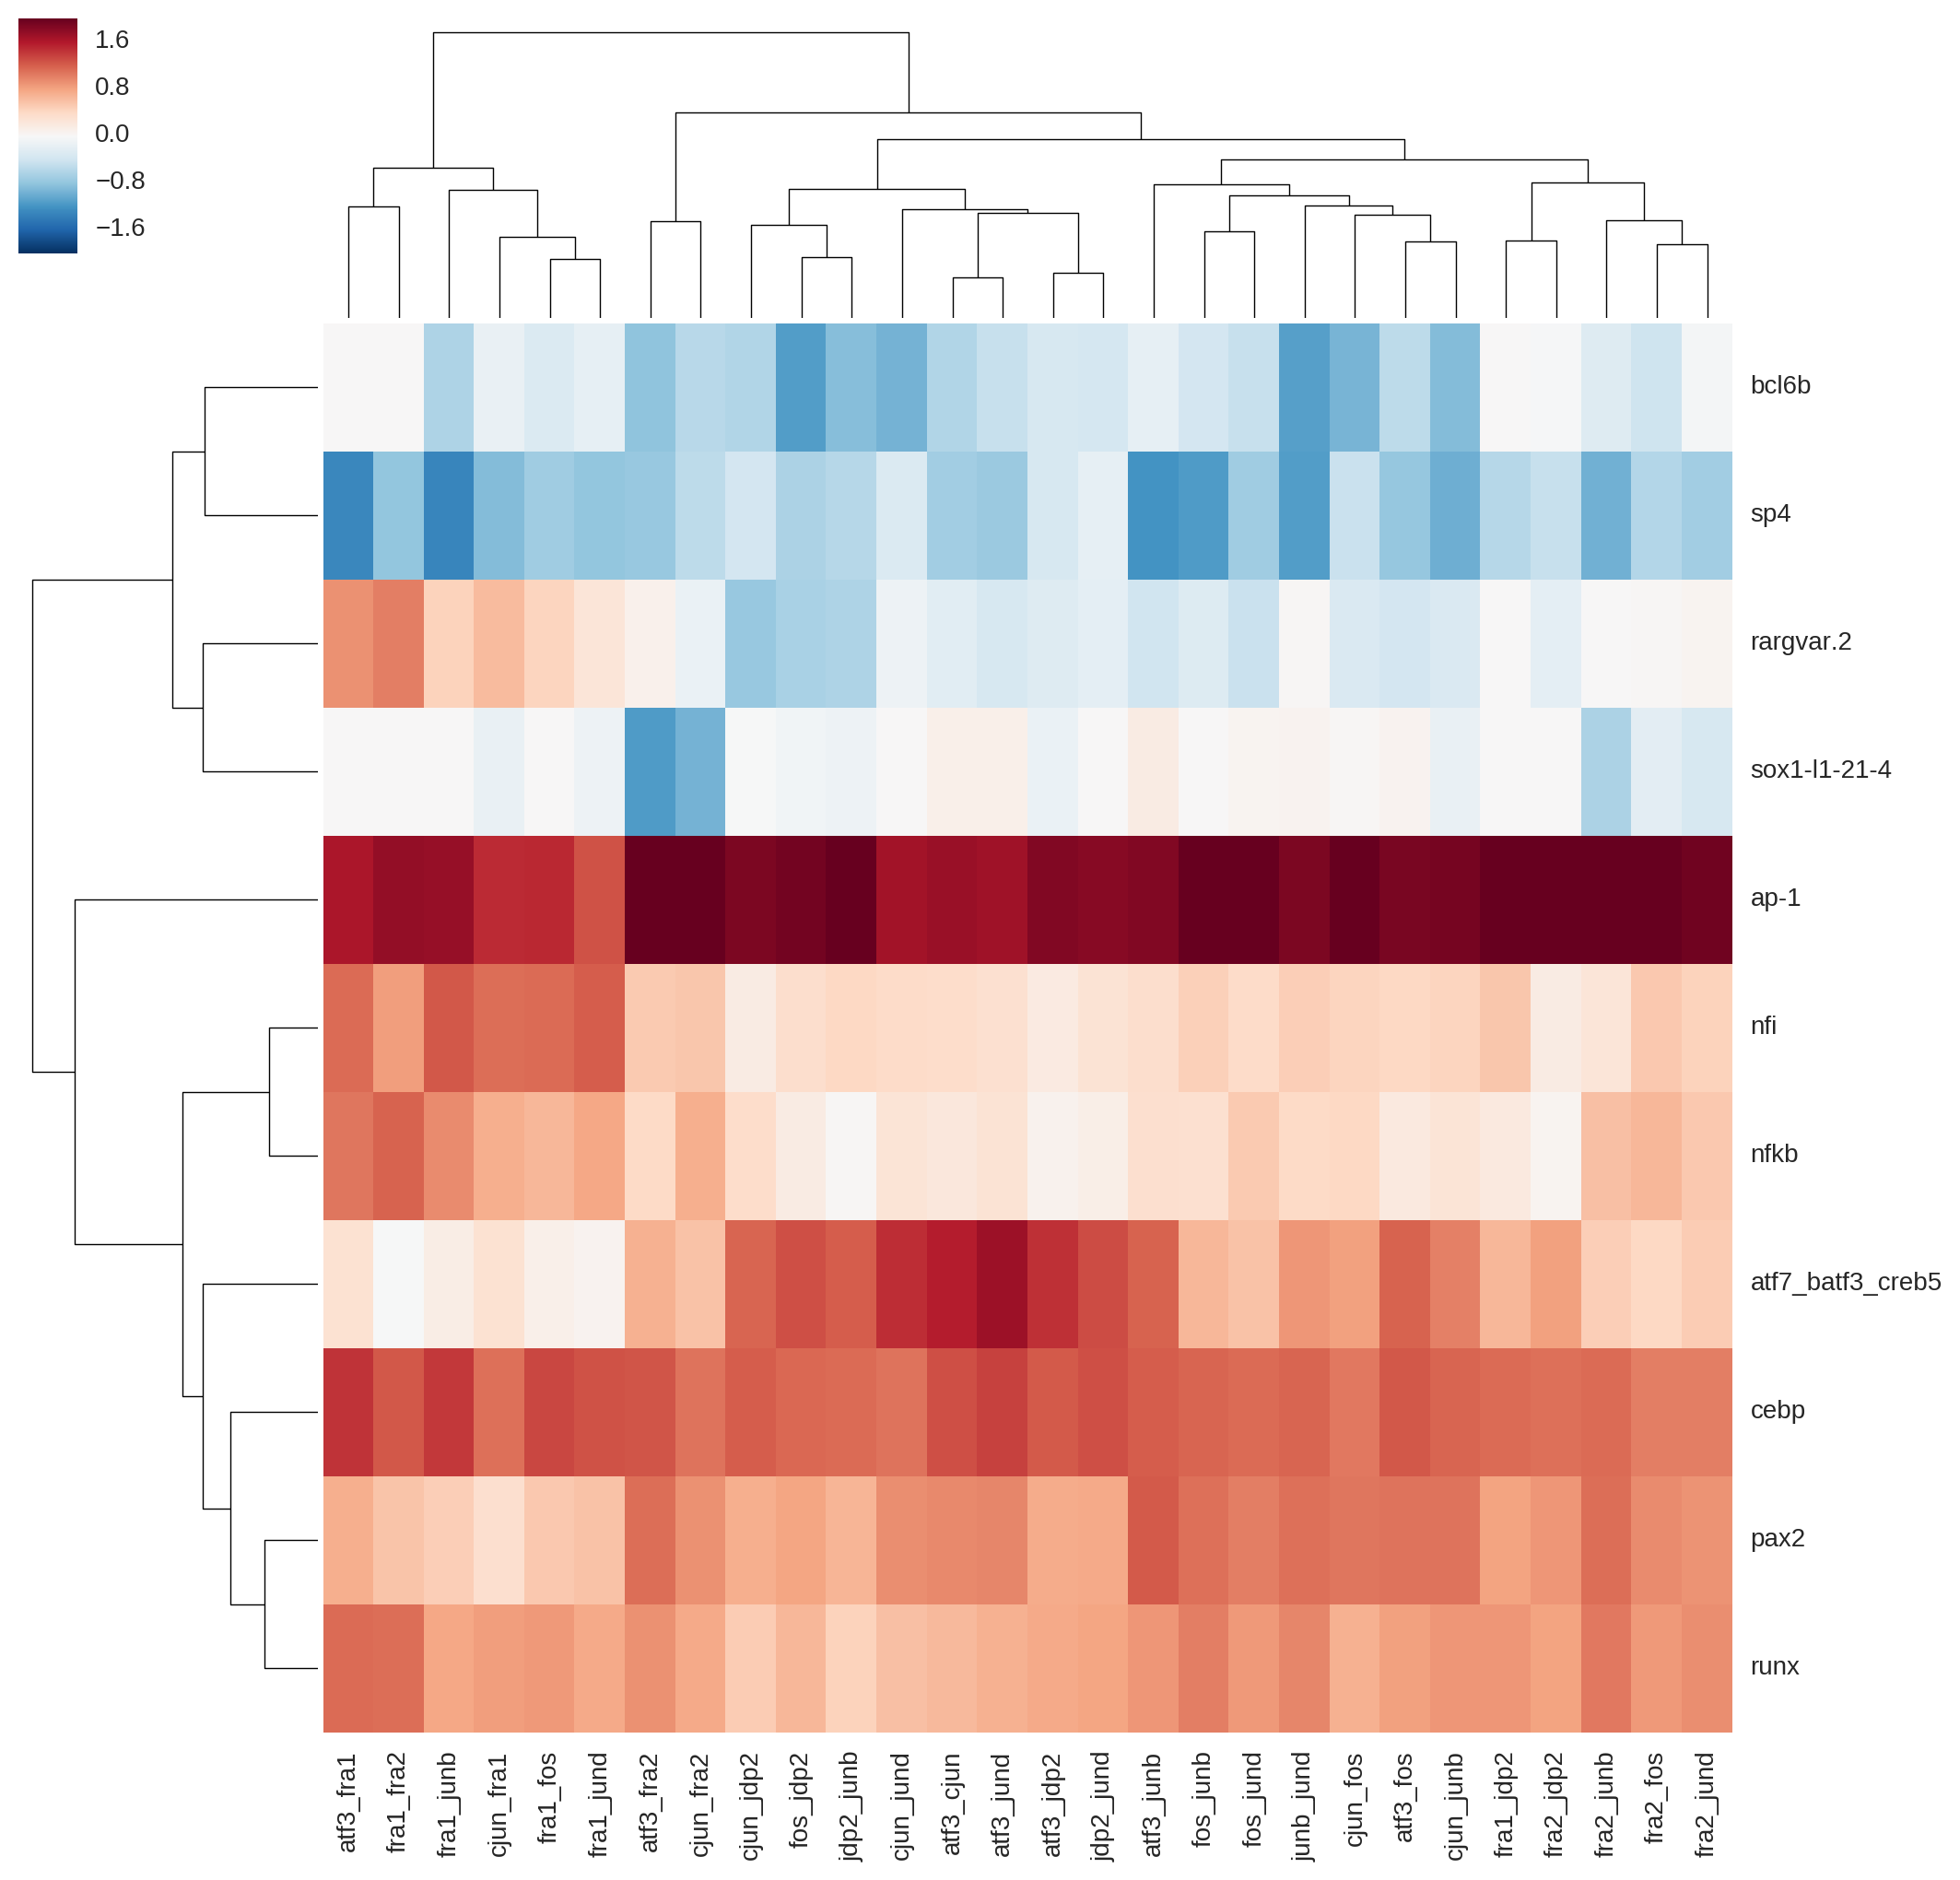

In [223]:
### plot coefficents for kla
weight_threshold = 1.0

cg = sns.clustermap(coefficients_frame_kla_pairs[(coefficients_frame_kla_pairs.max(axis=1) >= weight_threshold) |
                                       (coefficients_frame_kla_pairs.min(axis=1) < -1 * weight_threshold)
                                      ],
                   vmax=-2,
                   vmin=2,
                   center = 0.0,
#                    annot=True,annot_kws={"size": 4},
                   figsize=(12,12),
                   xticklabels=[x.replace('c57bl6_','') for x in coefficients_frame_kla_pairs.columns.values])
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);
plt.savefig('./figures/figure_05_c.svg', bbox_inches='tight')

### Barplots showing inducible RNA-seq expression for significant motifs that are different between vehicle and KLA for cjun-jund, cjun-fos, atf3-cjun, atf3-jund, (all pairs with more than 5k peaks before and after treatment

# Figure 6 - Strains Based Confirmation

# Figure 7 - Validation Experiment

# Figure 8 - RNA-seq and GRO-seq

### Scatter plot for jun knockdown (wt-veh vs siJun-veh)

### Scatter plot for jun knockdown (wt-KLA vs siJun-KLA)

### Scatter plot comparing two knockdowns (siATF3 vs siJun veh)

### GO analysis for knockdowns as a heatmap

### GRO-seq fold change plot for AP-1 dimers

### GO analysis for nearest gene

# Figure 9 - Graphical abstract

# Supplemental Materials

### Classifier performance on different test fractions

### De novo motifs for all dimers

### Motif compression stuff